# How quickly does semantics change

In [1]:
from koselleck import *
FN_DATA_PACEOFCHANGE

'/home/ryan/github/koselleck/data/data.semantic_change_over_decades.1run.v10-local-k50-halfdec.pkl'

In [2]:
DF=pd.read_pickle(FN_DATA_PACEOFCHANGE).reset_index()
DF

word      dist  \
0            cider  1.447276   
1            thorn  1.311074   
2        remission  1.286927   
3           revolt  1.207021   
4             lope  1.156108   
...            ...       ...   
2935653     sonata  0.006200   
2935654       coat  0.006150   
2935655        sky  0.006044   
2935656   concerto  0.005469   
2935657    quartet  0.004762   

                                             neighborhood1  \
0        -presbytery, -fund, -brig, -navy, -discharge, ...   
1        -bias, -feeling, -song, -clan, -wand, -digesti...   
2        -preferment, -support, -authority, -usage, -fu...   
3        -diet, -truck, -attack, -receiver, -viceroy, -...   
4        -conscience, -heart, -innocence, -passion, -ex...   
...                                                    ...   
2935653  concerto, prelude, andante, symphony, fantasia...   
2935654  collar, cap, shirt, jacket, nose, waistcoat, n...   
2935655  cloud, breeze, sunlight, mist, glow, horizon, ...   
2935656  sonata, prelude, quintet, overture, symphony, ...   
2935657  trio, quintet, prelude, overture, symphony, so...   

                                             neighborhood2    period1  \
0        +evidence, +homer, +algebra, +tongue, +liquor,...  1720-1725   
1        +tumult, +tribunal, +constitution, +senate, +c...  1720-1725   
2        +regiment, +troop, +cart, +worsted, +velvet, +...  1720-1725   
3        +china, +pot, +storm, +yoke, +bladder, +hurric...  1720-1725   
4        +twin, +commencement, +collector, +tern, +roan...  1720-1725   
...                                                    ...        ...   
2935653  fugue, concerto, adagio, prelude, finale, anda...  1890-1895   
2935654  waistcoat, collar, cap, shirt, neck, jacket, s...  1890-1895   
2935655  cloud, sunshine, sun, radiance, breeze, sunlig...  1890-1895   
2935656  sonata, symphony, quintet, overture, quartet, ...  1890-1895   
2935657  overture, trio, quintet, concerto, prelude, sc...  1890-1895   

           period2  
0        1725-1730  
1        1725-1730  
2        1725-1730  
3        1725-1730  
4        1725-1730  
...            ...  
2935653  1895-1900  
2935654  1895-1900  
2935655  1895-1900  
2935656  1895-1900  
2935657  1895-1900  

[2935658 rows x 6 columns]

In [3]:
words=set(DF.word)
len(words)

5982

In [4]:
def do_measure_rateofchange(gdf,**y):
    distdf=get_distmatrix_rateofchange(DF, words=set(gdf.word))
    return test_novelty(distdf,**y)

def measure_rateofchange(idf,lim=None,num_proc=1,**kwargs):
    return pmap_groups(
        do_measure_rateofchange,
        idf.iloc[:lim].groupby('word'),
        num_proc=num_proc,
        desc='Measuring rate of change in all words',
        kwargs=kwargs
    )

In [5]:
# idf=pd.DataFrame([{'word':w} for w in words])
# res=do_measure_rateofchange(idf[idf.word=='culture']).sort_values(
#     'foote_novelty',ascending=False)
# res

In [6]:

FN_NOVELTY_DATA=os.path.join(PATH_DATA,'data.words_by_rateofchange.v4.pkl')
# FN_NOVELTY_DATA=os.path.join(PATH_DATA,FN_DATA_PACEOFCHANGE.replace('.pkl','.novelty-measured.pkl'))
def get_novelty_data(ifn=FN_NOVELTY_DATA,num_proc=4,words=words):
    #gen/load
    if not os.path.exists(ifn):
        idf=pd.DataFrame([{'word':w} for w in words])
        allres=measure_rateofchange(idf,lim=None,num_proc=num_proc)
        allres.to_pickle(ifn)
    else:
        allres = pd.read_pickle(ifn)
    
    # filter
    allres = allres.query('foote_novelty!=0')
    allres['is_signif']=[int(x<0.05)# or y<0.01)
                        for x,y in zip(allres.p_peak,allres.p_trough)]
    allres['foote_size']=allres.foote_size.apply(int)
    allres['year']=allres.year.apply(int)
    allres = pd.concat(grp.assign(glen=len(grp)) for i,grp in allres.groupby(['foote_size','year'])).reset_index()
    allres = pd.concat(
        grp.sort_values('year').assign(
            foote_novelty_z=((grp.foote_novelty - grp.foote_novelty.dropna().mean()) / grp.foote_novelty.dropna().std())
        )#.set_index('year').rolling(rolling,min_periods=min_periods).mean()
        for i,grp in allres.groupby('foote_size')
    )
    return allres

In [7]:
allres=get_novelty_data(num_proc=6)
allres

word  year  foote_novelty  foote_size  p_peak  p_trough  \
0              abbe  1730       1.201551           2    0.52      1.00   
2210            pit  1730       1.012427           2    0.46      1.00   
2211          pitch  1730       1.011627           2    0.90      1.00   
2212           pith  1730       1.908225           2    0.98      1.00   
2213           pity  1730       0.961692           2    0.01      1.00   
...             ...   ...            ...         ...     ...       ...   
681595   exhaustion  1865       1.492409           6    1.00      0.19   
681594      exhaust  1865       7.483163           6    0.37      1.00   
681593     exertion  1865       1.658596           6    1.00      1.00   
681651  familiarity  1865       0.957187           6    1.00      1.00   
685032      zoology  1865       1.659076           6    0.91      1.00   

        is_signif  glen  foote_novelty_z  
0               0  3323         1.768272  
2210            0  3323         1.317744  
2211            0  3323         1.315838  
2212            0  3323         3.451695  
2213            1  3323         1.196885  
...           ...   ...              ...  
681595          0  5150        -0.436032  
681594          0  5150         2.370555  
681593          0  5150        -0.358176  
681651          0  5150        -0.686776  
685032          0  5150        -0.357951  

[685033 rows x 9 columns]

In [8]:
# allres[allres.word=='culture'].sort_values('foote_novelty',ascending=False).query('4<=foote_size<=6')

In [9]:
def get_novelty_classes(val='p_peak'):
    calld={}
    for w,wdf in allres.groupby('word'):
        if any(x<.001 for x in wdf[val]):
            calld[w]='Novelty+++'
        if any(x<.01 for x in wdf[val]):
            calld[w]='Novelty++'
        if any(x<.05 for x in wdf[val]):
            calld[w]='Novelty+'
        else:
            calld[w]=''
    return pd.Series(calld)

In [10]:
call=get_novelty_classes()
allres=allres.set_index('word')
allres['call']=get_novelty_classes()
allres=allres.reset_index()

In [11]:
allres[(allres.call=='Novelty+') & (allres.foote_size==6)].groupby('word').mean().sort_values('foote_novelty',ascending=False)

year  foote_novelty  foote_size    p_peak  p_trough  is_signif  \
word                                                                            
slate   1807.500000      15.918840         6.0  0.762500  0.787500   0.166667   
sort    1807.500000      15.888724         6.0  0.687917  0.769167   0.250000   
muff    1801.052632      15.385834         6.0  0.706316  0.845263   0.210526   
mutt    1793.055556      15.001900         6.0  0.717778  0.697778   0.222222   
fee     1807.500000      14.560880         6.0  0.770833  0.629167   0.166667   
...             ...            ...         ...       ...       ...        ...   
rock    1807.500000       0.638664         6.0  0.962083  0.797500   0.000000   
window  1807.500000       0.637417         6.0  0.943333  0.809167   0.000000   
bosom   1807.500000       0.600283         6.0  0.972500  0.556667   0.000000   
cloud   1807.500000       0.591027         6.0  0.984167  0.307083   0.000000   
spray   1820.000000       0.556023         6.0  0.872632  0.438421   0.052632   

               glen  foote_novelty_z  
word                                  
slate   4733.791667         6.322554  
sort    4733.791667         6.308445  
muff    4638.684211         6.072848  
mutt    4538.777778         5.892980  
fee     4733.791667         5.686368  
...             ...              ...  
rock    4733.791667        -0.836000  
window  4733.791667        -0.836584  
bosom   4733.791667        -0.853981  
cloud   4733.791667        -0.858317  
spray   4973.842105        -0.874716  

[2182 rows x 8 columns]

In [12]:
vsign=allres[allres.p_peak<0.01]
vsign.word.value_counts()
# vsign

trait        12
fame         12
sort         12
ruffian      11
foil         11
             ..
bulletin      1
december      1
stoop         1
turnip        1
departure     1
Name: word, Length: 1041, dtype: int64

In [13]:


def get_figdf(vsign,rolling=2,min_periods=1,foote_sizes={3,4,5},gby=['foote_size','year']):
#     figdf_mean=vsign.groupby(['foote_size','year']).mean().reset_index()
#     figdf_mean=figdf_mean[~figdf_mean.foote_novelty.isna()]
    figdf_mean = pd.concat(grp.assign(glen=len(grp)) for i,grp in vsign.groupby(gby))
    figdf_mean = figdf_mean.groupby(gby).mean().reset_index()
    if rolling>1:
#         display(figdf_mean)
#         for i,grp in figdf_mean.groupby(gby[:-1]): pass
#         display(grp.set_index(gby+['is_signif']).sort_index())
#         display(grp.set_index(gby+['is_signif']).sort_index().rolling(3,min_periods=1).mean())
        
        figdf_mean = pd.concat(
            grp.set_index(
                gby+['is_signif'],
            ).sort_index().rolling(
                rolling,
                min_periods=min_periods
            ).mean()
            for i,grp in figdf_mean.groupby(gby[:-1])
        ).reset_index()
#         display(figdf_mean)
    ywl=[
        f'{x} years'
        for x in figdf_mean['foote_size']*5*2
    ]
    ywls=set(ywl)
    ywll=list(reversed(sorted(list(ywls))))
    figdf_mean['year_window']=pd.Categorical(ywl, categories=ywll)
    return figdf_mean.dropna()#.groupby(['year','foote_size']).mean().reset_index(z)

In [14]:
get_figdf(vsign,rolling=2)#,gby=['foote_size','word','year'],rolling=2,min_periods=1)

foote_size  year  is_signif  foote_novelty  p_peak  p_trough  glen  \
0             2  1730          1       2.335893     0.0       1.0  53.0   
1             2  1735          1       2.680527     0.0       1.0  33.0   
2             2  1740          1       2.815634     0.0       1.0   7.5   
3             2  1745          1       2.807151     0.0       1.0   4.0   
4             2  1750          1       2.716132     0.0       1.0   6.5   
..          ...   ...        ...            ...     ...       ...   ...   
130           6  1845          1      10.013068     0.0       1.0  19.0   
131           6  1850          1      10.576365     0.0       1.0  15.5   
132           6  1855          1      11.141237     0.0       1.0  15.5   
133           6  1860          1      10.752690     0.0       1.0  18.5   
134           6  1865          1      11.207370     0.0       1.0  19.5   

     foote_novelty_z year_window  
0           4.470476    20 years  
1           5.291454    20 years  
2           5.613303    20 years  
3           5.593096    20 years  
4           5.376271    20 years  
..               ...         ...  
130         3.555781    60 years  
131         3.819677    60 years  
132         4.084312    60 years  
133         3.902283    60 years  
134         4.115295    60 years  

[135 rows x 9 columns]

In [15]:
get_figdf(vsign,rolling=10)#,gby=['foote_size','word','year'],rolling=2,min_periods=1)

foote_size  year  is_signif  foote_novelty  p_peak  p_trough       glen  \
0             2  1730          1       2.335893     0.0       1.0  53.000000   
1             2  1735          1       2.680527     0.0       1.0  33.000000   
2             2  1740          1       2.655720     0.0       1.0  22.666667   
3             2  1745          1       2.743839     0.0       1.0  18.500000   
4             2  1750          1       2.679885     0.0       1.0  16.200000   
..          ...   ...        ...            ...     ...       ...        ...   
130           6  1845          1      13.081027     0.0       1.0  40.700000   
131           6  1850          1      12.573717     0.0       1.0  35.800000   
132           6  1855          1      11.913891     0.0       1.0  30.900000   
133           6  1860          1      11.289623     0.0       1.0  26.200000   
134           6  1865          1      10.824723     0.0       1.0  23.400000   

     foote_novelty_z year_window  
0           4.470476    20 years  
1           5.291454    20 years  
2           5.232361    20 years  
3           5.442275    20 years  
4           5.289925    20 years  
..               ...         ...  
130         4.993077    60 years  
131         4.755410    60 years  
132         4.446290    60 years  
133         4.153829    60 years  
134         3.936030    60 years  

[135 rows x 9 columns]

In [16]:
UPROOT='/Markdown/Drafts/TheGreatAbstraction/figures/'
def upfig(fnfn,uproot=UPROOT):
    ofnfn=os.path.join(uproot,os.path.basename(fnfn))
    cmd=f'dbu upload {fnfn} {ofnfn}'
    !{cmd}
    cmd = f'dbu share {ofnfn}'
    !{cmd}

In [17]:
def plot_distmat(distdf,xcol='period_int1',ycol='period_int2',value_name='value',use_color=False,xlim=None,ylim=None,title='Distance matrix',ofn=None,invert=False,**y):
    ddf=distdf
    
    
    distdfm=distdf.reset_index().melt(id_vars=[xcol],value_name=value_name).dropna()
#     display(distdfm)
    
    fig=start_fig(
        distdfm,
        x=f'factor({xcol})',
        y=f'factor({ycol})',
        fill=value_name,
        **y
    )
    fig+=p9.geom_tile()
    if not use_color:
        if not invert:
            fig+=p9.scale_fill_gradient(high='#111111',low='#FFFFFF')   
        else:
            fig+=p9.scale_fill_gradient(low='#111111',high='#FFFFFF')   
    else:
        fig+=p9.scale_fill_distiller(type='div',palette=5)
    fig+=p9.theme(
        axis_text_x=p9.element_text(angle=90)
    )
    fig+=p9.labs(
        x='Date of semantic model',
        y='Date of semantic model',
        fill='Semantic distance (LNM)',
        title=title
    )
    if ofn:
        ofnfn=os.path.join(PATH_FIGS,ofn)
        fig.save(ofnfn)
        upfig(ofnfn)
        #fig.save(os.path.join('/home/ryan/Markdown/Drafts/TheGreatAbstraction/figures', ofn))
        
    return fig

In [18]:
# get_distmatrix_rateofchange??

In [19]:
# @interact
def showdist(w='culture'):
    distdf=get_distmatrix_rateofchange(DF,words=set(wx.strip() for wx in w.split(',')))
    return plot_distmat(
        distdf,
        use_color=False,
        figure_size=(8,8),
        ofn=f'fig.distmat.{w}.v33.png',
        title=f'Historical-semantic distance matrix for ‘{w}’'
    )

> Skipping file "/home/ryan/github/koselleck/figures/fig.distmat.station.v33.png", file exists with the same hash
 > Share link: https://www.dropbox.com/s/nmjxfc6fp0549qi/fig.distmat.station.v33.png?dl=0


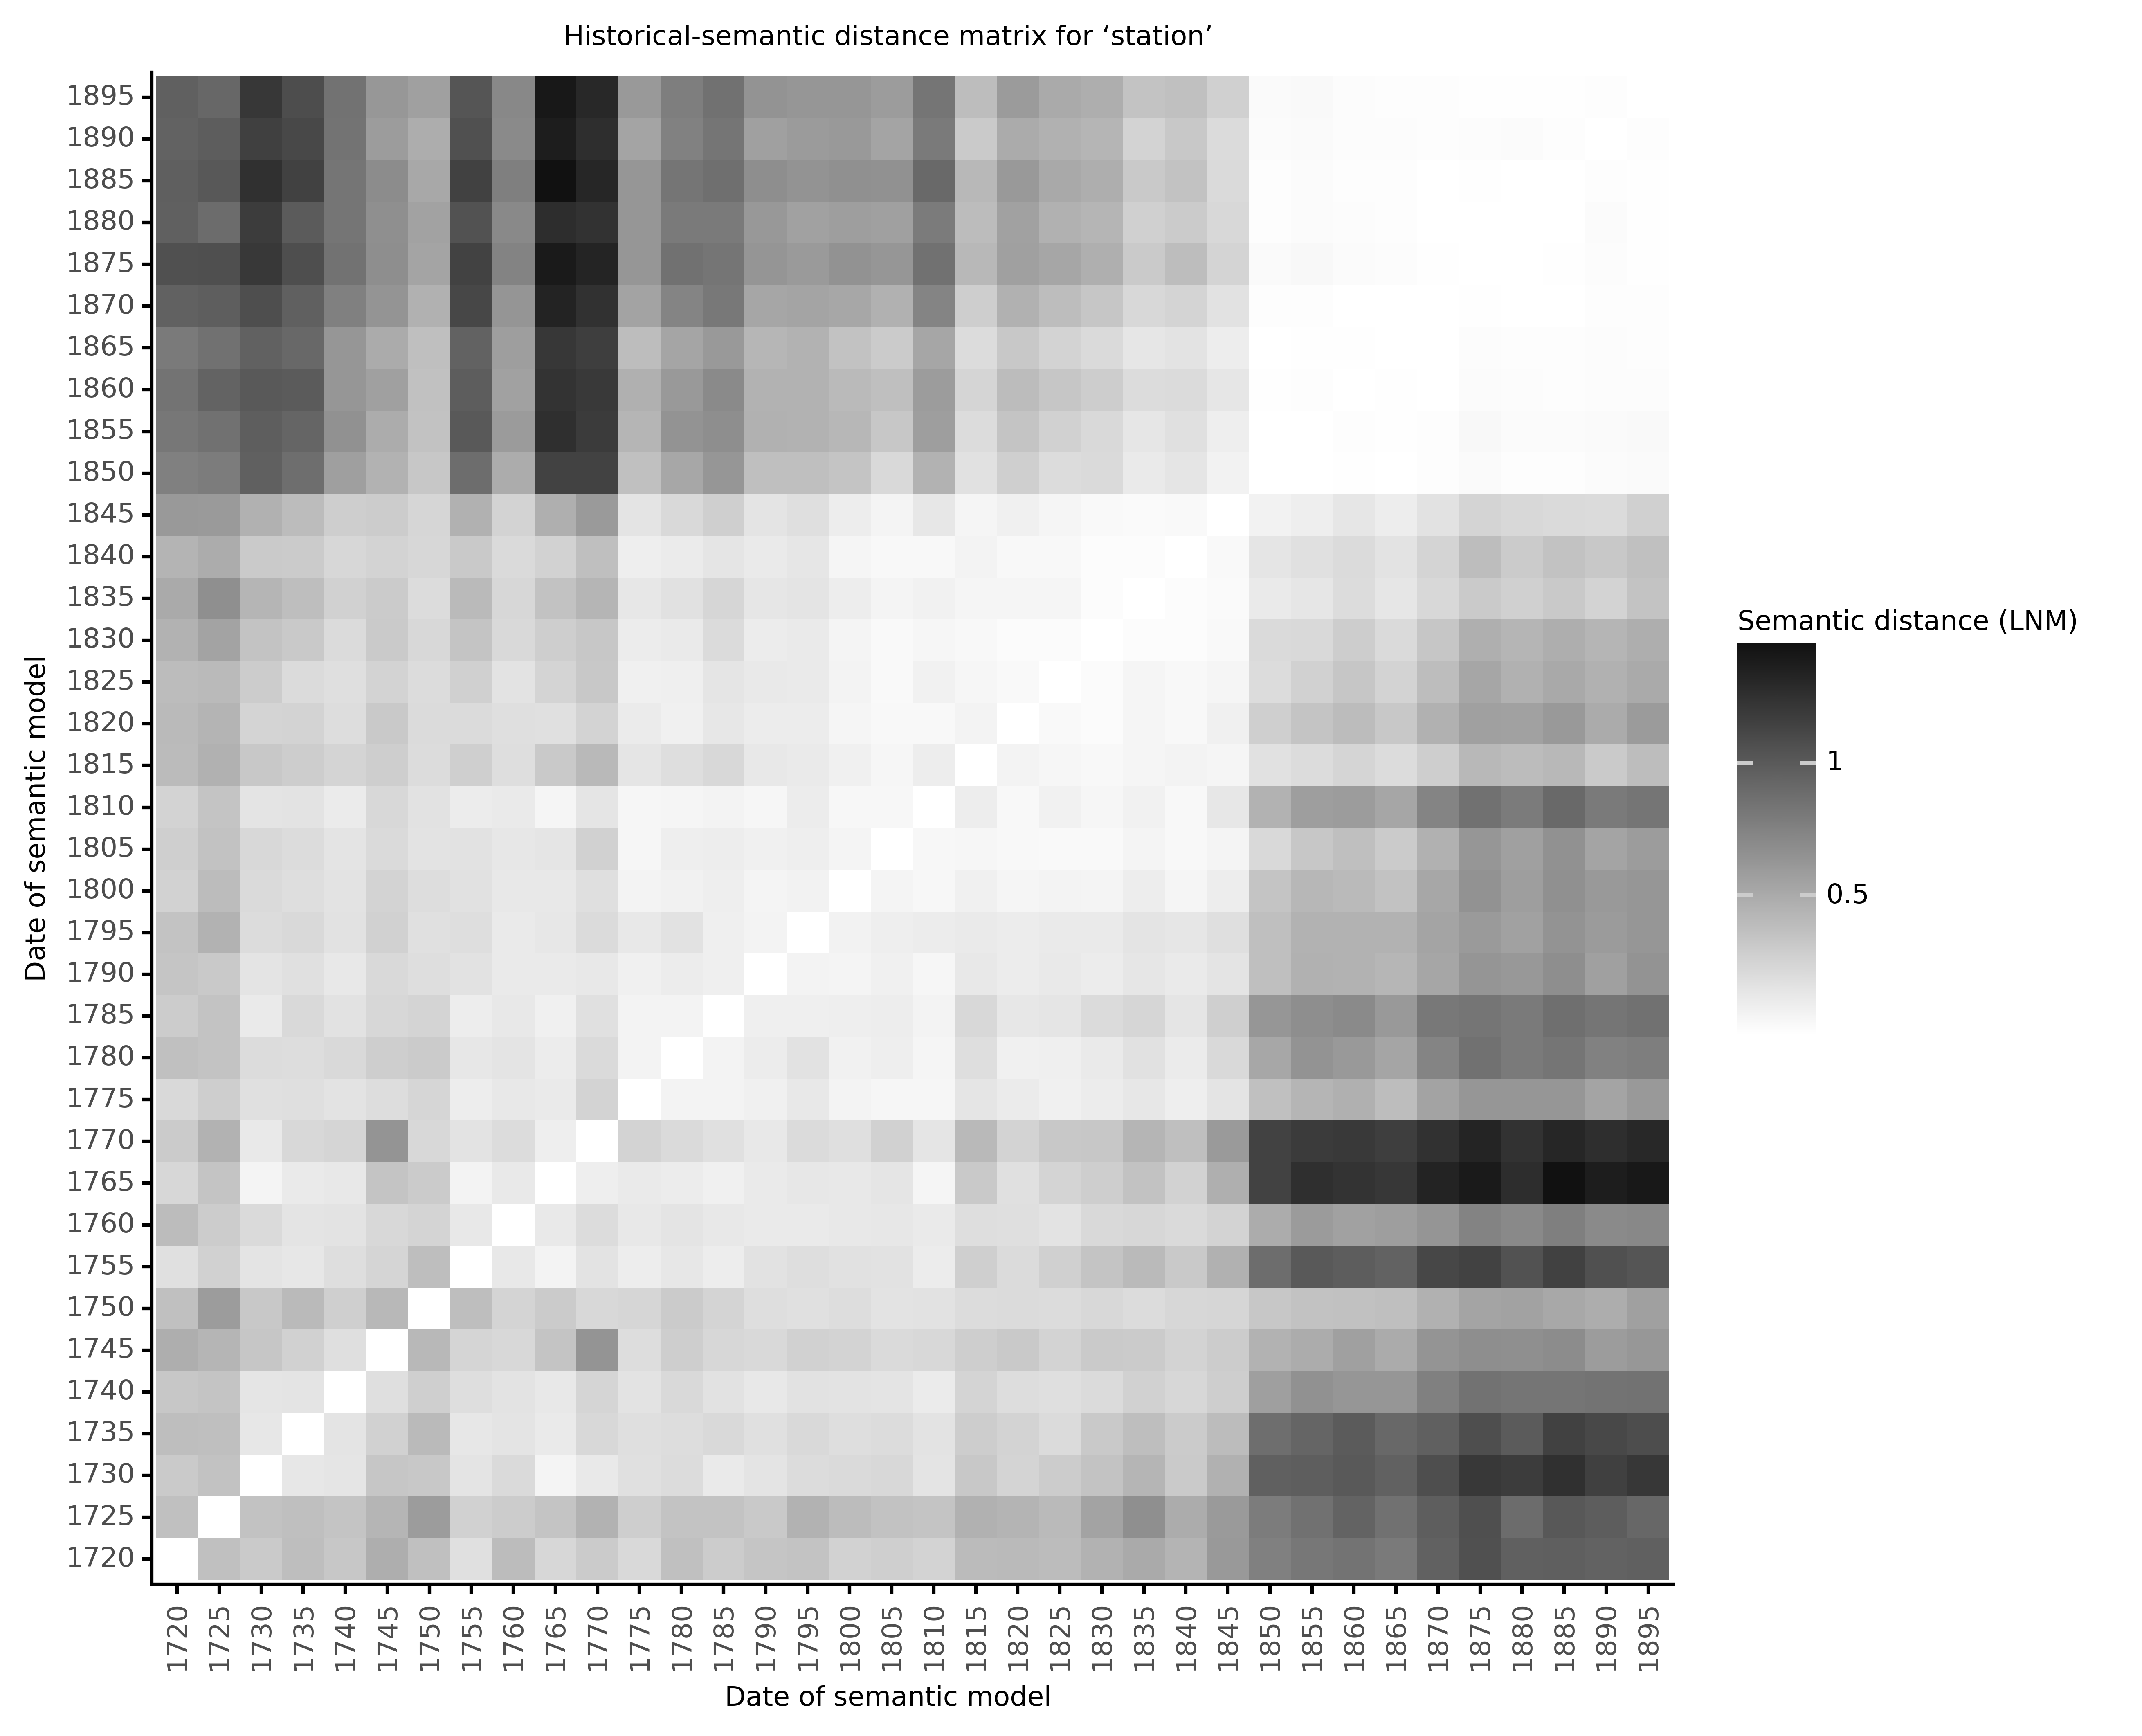

<ggplot: (8793682156253)>

In [20]:
# showdist('culture')
showdist('station')

In [53]:
# @interact
def show_novelty(
        allres=allres,
    
        color='factor(year_window)',
        group='factor(year_window)',
        shape='factor(year_window)',
        size='glen',
        max_p_peak=0.01,
        vnum='v9',
        showdata=False,
        xlab='Date of semantic model',
        ylab='Foote Novelty (standardized)',
        colorlab='Foote matrix width',
        shapelab='Foote matrix width',
        sizelab='Number of significant peaks',
        title='Average novelty score for significant words over time',
        rolling=2,
        min_periods=1,
        min_foote_size=6,
        max_foote_size=6,
        y='foote_novelty',
        ymin=-.1,
        ylim0=0,
        ylim1=20,
        use_ylim=False,
        xlim0=1750,
        xlim1=1900,
        sizemin=.25,
        sizemax=2,
        labsize=6,
        hline='',
        nudge_label_y=1,
        ymin_heatmap=1750,
        combine=True,
        use_color=False,
        h_fig1=4.00,
        h_fig2=4.00,
        nudge_x=3,
        xlab_min=1735,
        add_median=True,
        save=False,
        label_words=False,
        logy=False,
        show_period_labels=True,
        dist_invert_fill=False,
        line_size=0.5,
        label_size=7,
        words='',
        ):

    figdf=allres.query(f'{min_foote_size}<=foote_size<={max_foote_size}')
    if words:
        words=set(tokenize_fast(words))
        figdf=figdf[figdf.word.isin(words)]
        gby=['word','year','foote_size']
        figdf=figdf.groupby(gby).mean().reset_index()
#         display(figdf)
    else:
        gby=['foote_size','year']
    if max_p_peak:
        figdf=figdf[figdf.p_peak<max_p_peak]
    if not len(figdf): return
    figwords=set(figdf.word)
    if 'significant words' in title:
        title=title.replace('significant words',f'significant (p<{round(max_p_peak,2)}) words')
    
    
    figdf=get_figdf(figdf,
        rolling=rolling,
        min_periods=min_periods,
        foote_sizes=set(range(min_foote_size,max_foote_size+1)),
        gby=gby
    )
    figdf['is_signif']=pd.Categorical(
        [bool(x>0) for x in figdf.is_signif],
        categories=[True,False]
    )
    
    figdf=figdf.sort_values('year')
#     display(figdf)
    if showdata: display(figdf)
#     print(f'y = {y}')
    fig=start_fig(
        figdf,
        x='year',
        y=y,
        color=color if color else None,
        group=group if group else None,
        figure_size=(8,h_fig1)
    )
    
    if add_median:
        kname='Guides'
        mediandf=pd.DataFrame([{
            'yintercept':figdf[y].median(),
            kname:'Median',
        },
#         {
#             'yintercept':0,
#             kname:'Zero novelty'
#         }
        ])
        fig+=p9.geom_hline(
            p9.aes(yintercept='yintercept',linetype=kname),
            data=mediandf,
            size=.25,
            show_legend=True
        )
        #fig+=p9.geom_text(inherit_aes=False,y=figdf[y].median()+.1,x=xlab_min,size=6,alpha=.8,ha='center',label='Median')
    
            
    fig+=p9.geom_line(size=line_size)
    pntd={}
    if size: pntd['size']=size
    if shape: pntd['shape']=shape
    fig+=p9.geom_point(p9.aes(**pntd))
    # fig+=p9.geom_smooth()
#     fig+=p9.scale_color_distiller()
    
    
    fig+=p9.labs(x=xlab,y=ylab,title=title,color=colorlab,size=sizelab,shape=shapelab)
    if use_ylim: fig+=p9.ylim(ylim0,ylim1)
#     fig+=p9.xlim(xlim0,xlim1)
    fig+=p9.scale_size_continuous(range=(sizemin,sizemax))
    if not use_color: fig+=p9.scale_color_gray(direction=1)# if not use_color else p9.scale_color_distiller(type='qual')
    if hline not in {None,''}:
        fig+=p9.geom_hline(yintercept=hline,linetype='dotted')
#     fig+=p9.geom_smooth(p9.aes(x='year',y=y),inherit_aes=False)

    if words and label_words:
        labeldf=figdf[figdf.is_signif==1]
        grps=[
            grp.sort_values(y).iloc[-1:]
            for i,grp in labeldf.groupby('word')
        ]
        if len(grps):
            labeldf=pd.concat(grps)
            labeldf[y]+=nudge_label_y
            fig+=p9.geom_label(p9.aes(label='word'),color='black',
                               size=label_size,data=labeldf,boxcolor=(0,0,0,0))


    if show_period_labels:
        fig+=p9.geom_vline(xintercept=1770,linetype='dotted',alpha=0.5) 
        fig+=p9.geom_vline(xintercept=1800,linetype='dotted',alpha=0.5) 
        fig+=p9.geom_vline(xintercept=1830,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1750,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1850,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1789,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1815,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1848,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1830,linetype='dashed')
#     if False:
        fig+=p9.geom_label(label='Sattelzeit begins (1770)',x=1770+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0))
        fig+=p9.geom_label(label='Sattelzeit ends (1830)',x=1830+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
#         fig+=p9.geom_label(label='French Rev. (1789)',x=1789+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
#         fig+=p9.geom_label(label='Peak semantic change (1815)',x=1815+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
#         fig+=p9.geom_label(label='Revolutions of 1848',x=1848+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
    
    
    

    
    
#     fig+=p9.geom_vline(xintercept=1789,linetype='dotted',alpha=0.5) 
#     fig+=p9.geom_vline(xintercept=1815,linetype='dotted',alpha=0.5) 
#     fig+=p9.geom_vline(xintercept=1830,linetype='dashed')
    

#     xlim0,xlim1=figdf.year.min()//10*10,figdf.year.max()
    if size=='is_signif':
        fig+=p9.scale_size_manual({True:2,False:.2})
    else:
        fig+=p9.scale_size_continuous(range=[.25,3])
#     fig+=p9.scale_x_continuous(breaks=10)
    fig+=p9.theme_minimal()
    fig+=p9.theme(axis_text_x=p9.element_text(angle=90), text=p9.element_text(size=8))
    if logy: fig+=p9.scale_y_log10(limits=[ylim0,ylim1])
        
    
    
    
    #fig+=p9.scale_fill_gray()
    fig+=p9.scale_x_continuous(
        minor_breaks=list(range(xlim0//5*5,(xlim1//5*5)+5,5)),
        limits=[xlim0,xlim1]
    )
#     fig+=p9.xlim(xlim0,xlim1)

    if combine:
        yymin1=figdf.year.min()
        yymax1=figdf.year.max()
        distdf=get_distmatrix_rateofchange(DF, words=figwords,ymin=xlim0,ymax=xlim1)
        figdm=plot_distmat(
            distdf,
            figure_size=(8,h_fig2),
            use_color=use_color,
            title=f'(a) Historical-semantic distance matrix for ‘{list(words)[0]}’, {xlim0}-{xlim1} (BPO)',
            save=False,
            invert=dist_invert_fill
        )
        fig1,fig2=figdm,fig
    wkey='-'.join(words) if words else ''
    ofn=f'''fig.footenov.{vnum}.{wkey+'.' if wkey else ''}{'cmbo.' if combine else ''}png'''
    ofnfn=os.path.join(PATH_FIGS,ofn)
    ofig=combine_plots(fig1,fig2,ofn=ofnfn) if combine else fig
    display(ofig)
    if save and not combine: fig.save(ofnfn)
#     shutil.copyfile(
#         ofnfn,
#         f'/home/ryan/Markdown/Drafts/TheGreatAbstraction/figures/{ofn}'
#     )

    dbodir='/Markdown/Drafts/TheGreatAbstraction/figures/'
    ofn=os.path.basename(ofnfn)
    cmd1=f'dbu upload {ofnfn} {dbodir}'
    !{cmd1}
    cmd2=f'dbu share {dbodir}{ofn}'
    !{cmd2}

In [54]:
def show_word_novelty_allfoote(words,**y):
    title=f'(b) Foote Novelty scores for ‘{words}’, 1740-1875 (BPO)'
    return show_novelty(**{
        **dict(
            words=words,
            min_foote_size=4,
            max_foote_size=6,
            rolling=1,
            max_p_peak=0,
            vnum='v26',
            xlim0=1720,xlim1=1900,
            save=SAVE,
            title=title,
            size='is_signif',
            sizelab='Statistically signif.',
            dist_invert_fill=False,
            ylab='Foote Novelty',
            ylim1=-3
        ),
        **y
    })


In [55]:
# SAVE=1
# show_word_novelty_allfoote('culture',save=SAVE,vnum='v32')
# show_word_novelty_allfoote('station',save=SAVE,vnum='v32')


## All words

In [51]:
# figdf=allres
# #[~allres.word.str.contains('s')]
# res=interact_manual(
#     show,
#     allres=fixed(figdf),
#     y=['foote_novelty_z','foote_novelty','foote_novelty_z2'],
#     vnum='v18',
#     ylim1=5.5,
#     ymin=1.4,
#     ylim0=1.5,
#     use_ylim=False,
#     max_p_peak=0.05,
# #     ymin=1.5,
#     min_foote_size=4,
#     max_foote_size=6,
#     save=False,
#     rolling=1,
#     hline=fixed('')
# )

In [25]:
# allres.foote_

## Word novelties

In [26]:
def show_word_novelty(words='',**kwargs):
    words=','.join(words) if type(words)!=str else words
    inpd=dict(
        y='foote_novelty',
        words=words,
        color='word',
        group='word',
        shape='word',
        colorlab='Word',
        shapelab='Word',
        sizelab='Statistically significant',
        title='Novelty scores for key words',
        ylab='Foote Novelty score',
        size='is_signif',
        vnum='v19',
        use_ylim=True,
        add_median=True,
        max_p_peak=0.0,
        min_foote_size=6,
        max_foote_size=6,
        showdata=False,
        nudge_x=2,
        logy=True,
        ylim0=1,
        ylim1=40,
        rolling=2,
        ymin=.1,
        label_words=True,
        show_period_labels=True,
        nudge_label_y=1,
    )
    return show_novelty(**{**inpd, **kwargs})


### Many

In [57]:
words=[
    'labourer',
    'reform',
    'catastrophe',
    'demand',
#     'insurrection',
#         'value',
#     'institution',
    'circulation',
    'slave',
    'service',
#         'revolution',
#         'formula',
#         'slavery',
        'example',
#         'citizen',
        'interest',
#         'workmanship',
        'vehicle',
#         'disease',
#     'relationship'
]
len(words)

10

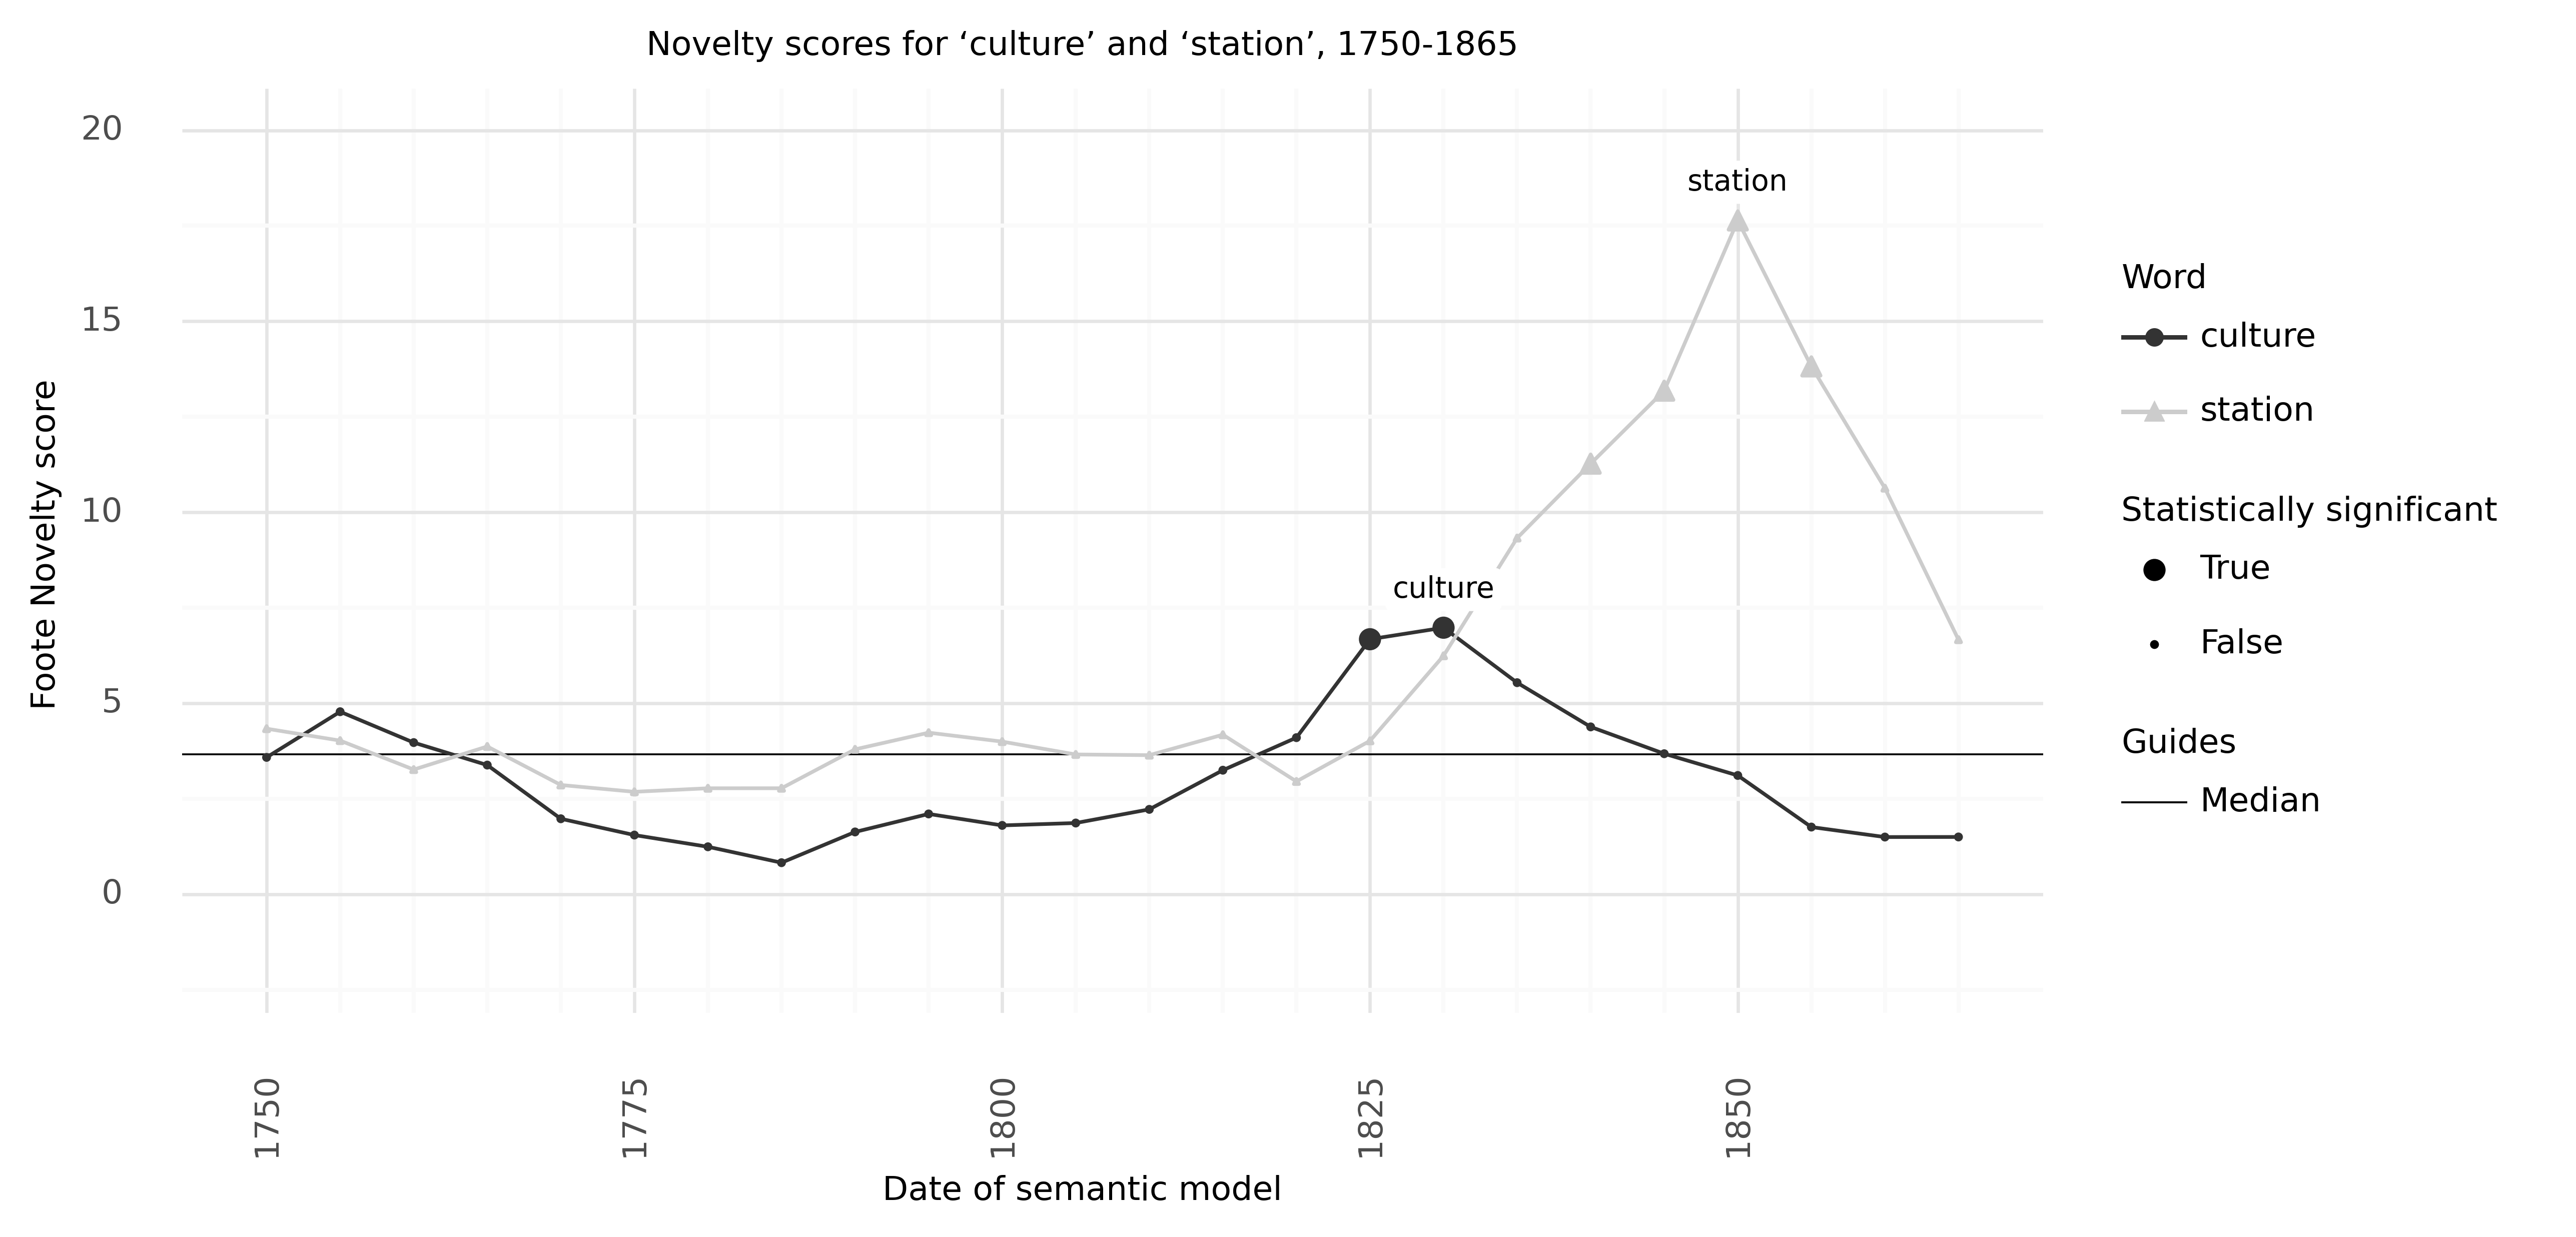

<ggplot: (8793748340229)>

 > Uploading "/home/ryan/github/koselleck/figures/fig.footenov.v30.station-culture.png" to "/Markdown/Drafts/TheGreatAbstraction/figures/fig.footenov.v30.station-culture.png"... DONE
 > Share link: https://www.dropbox.com/s/ojd5ulz914kxoxk/fig.footenov.v30.station-culture.png?dl=0


In [68]:
show_word_novelty(
    #words='crisis,reform,demand,',
#     words=words + ['station','culture'],
    words=['station','culture'],
    label_words=True,
    show_period_labels=0,
    nudge_label_y=1,
    ylim0=-2,
    ylim1=20,
    ymin=-2,
    rolling=1,
    vnum='v30',
    save=1,#SAVE,
    combine=False,
    xlim0=1750,
    xlim1=1865,
    h_fig1=4,
    logy=False,
    min_foote_size=6,
    max_foote_size=6,
#     line_size=.75
#     title='Novelty scores for key words, 1750-1865'
    title='Novelty scores for ‘culture’ and ‘station’, 1750-1865'
)

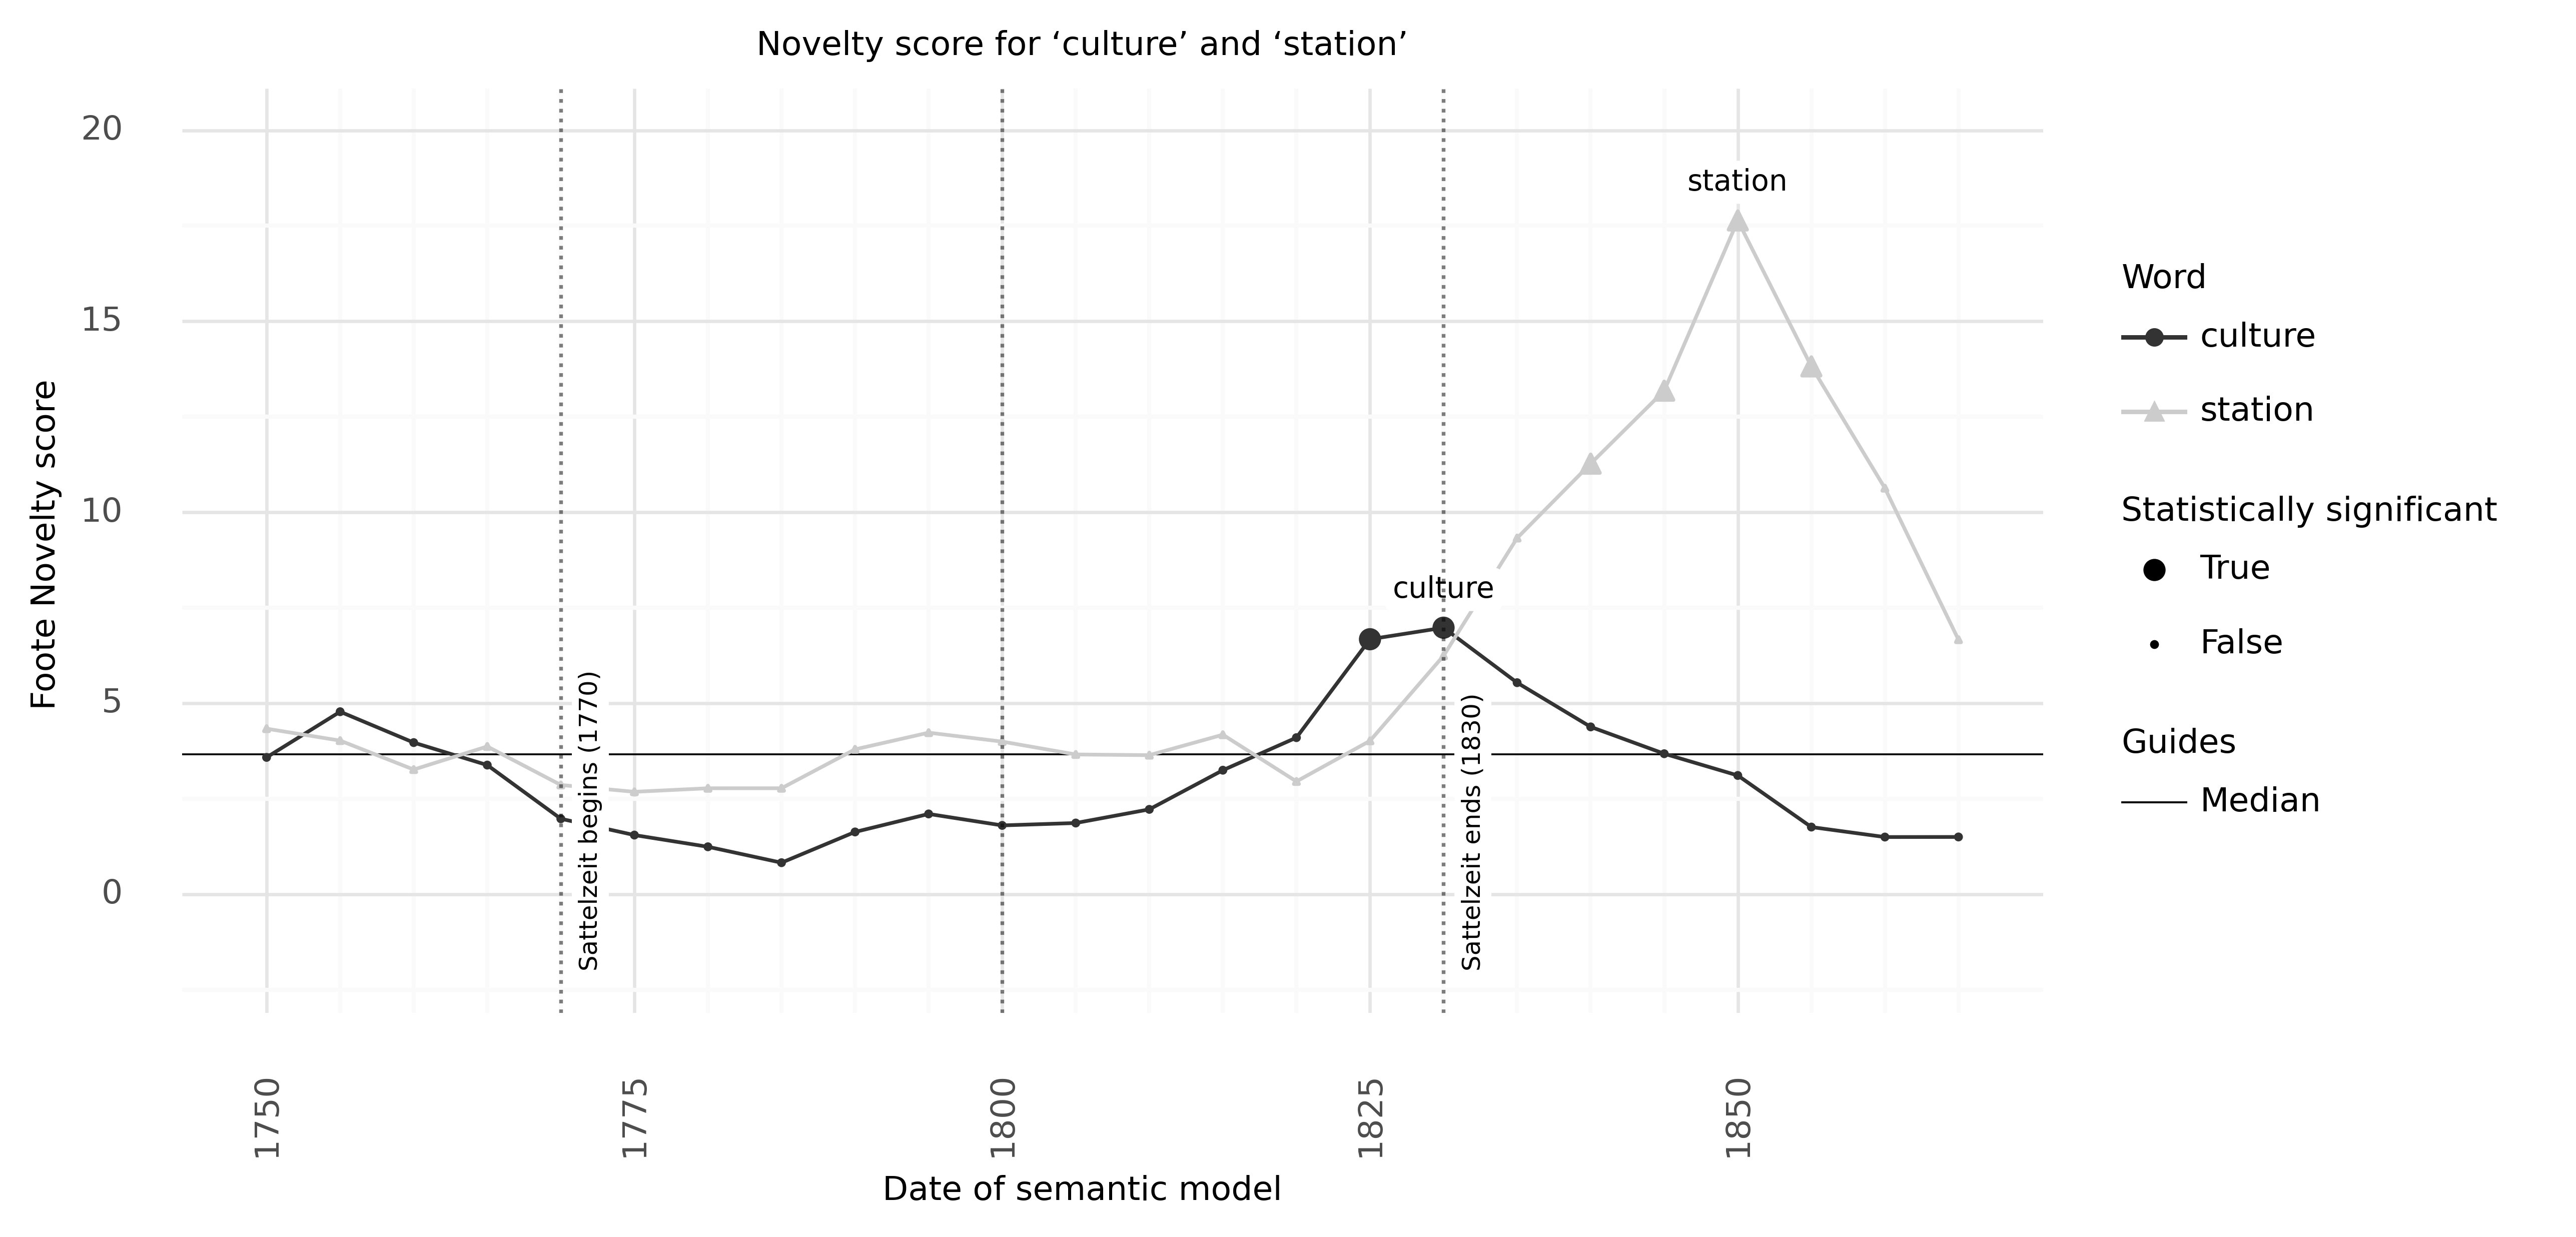

<ggplot: (8793752484613)>

> Skipping file "/home/ryan/github/koselleck/figures/fig.footenov.v28.station-culture.png", file exists with the same hash
 > Share link: https://www.dropbox.com/s/prquipfk4ta4104/fig.footenov.v28.station-culture.png?dl=0


In [67]:
show_word_novelty(
    #words='crisis,reform,demand,',
    words=[
        'station',
        'culture',
    ],
    label_words=True,
    show_period_labels=True,
    nudge_label_y=1,
    ylim0=-2,
    ylim1=20,
    ymin=-2,
    rolling=1,
    vnum='v28',
    save=SAVE,
    combine=False,
    h_fig1=4,
    logy=False,
#     line_size=.75
    xlim0=1750,
    xlim1=1865,
    min_foote_size=6,
    max_foote_size=6,
    title='Novelty score for ‘culture’ and ‘station’'
    
)

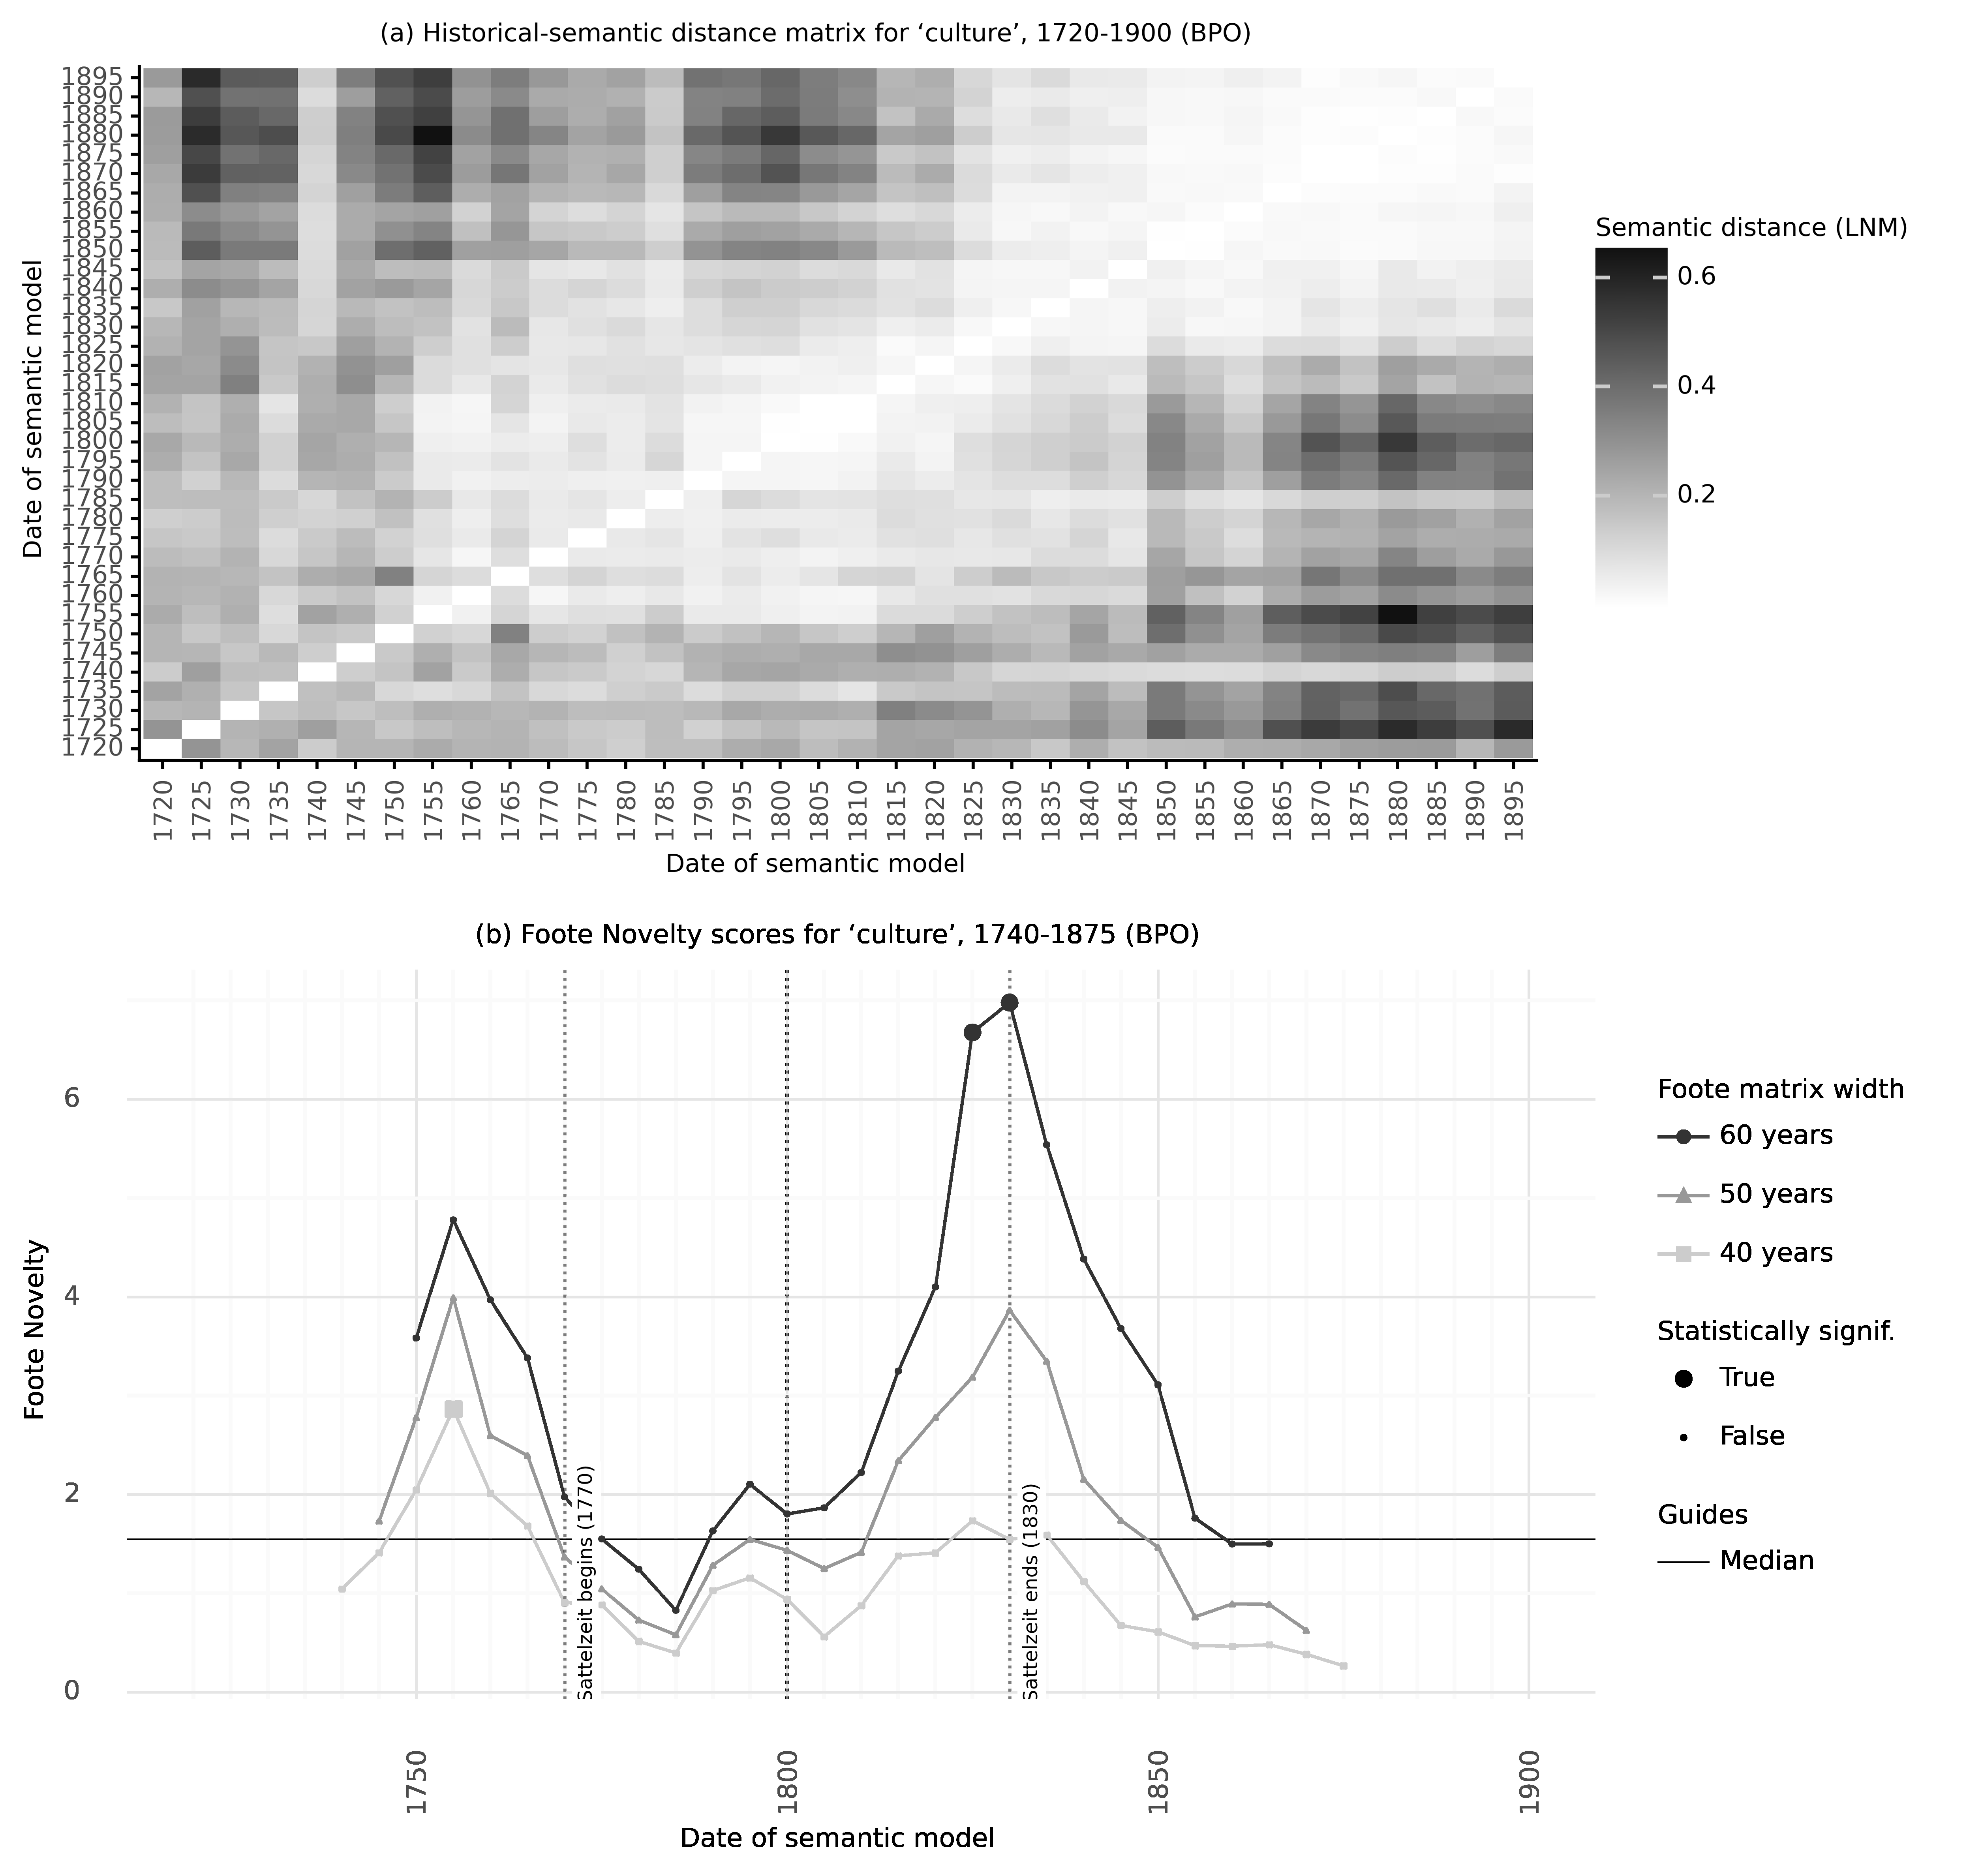

 > Uploading "/home/ryan/github/koselleck/figures/fig.footenov.v26.culture.cmbo.png" to "/Markdown/Drafts/TheGreatAbstraction/figures/fig.footenov.v26.culture.cmbo.png"... DONE
 > Share link: https://www.dropbox.com/s/bp7y33gg2aq83nj/fig.footenov.v26.culture.cmbo.png?dl=0


In [34]:
show_word_novelty_allfoote('culture')

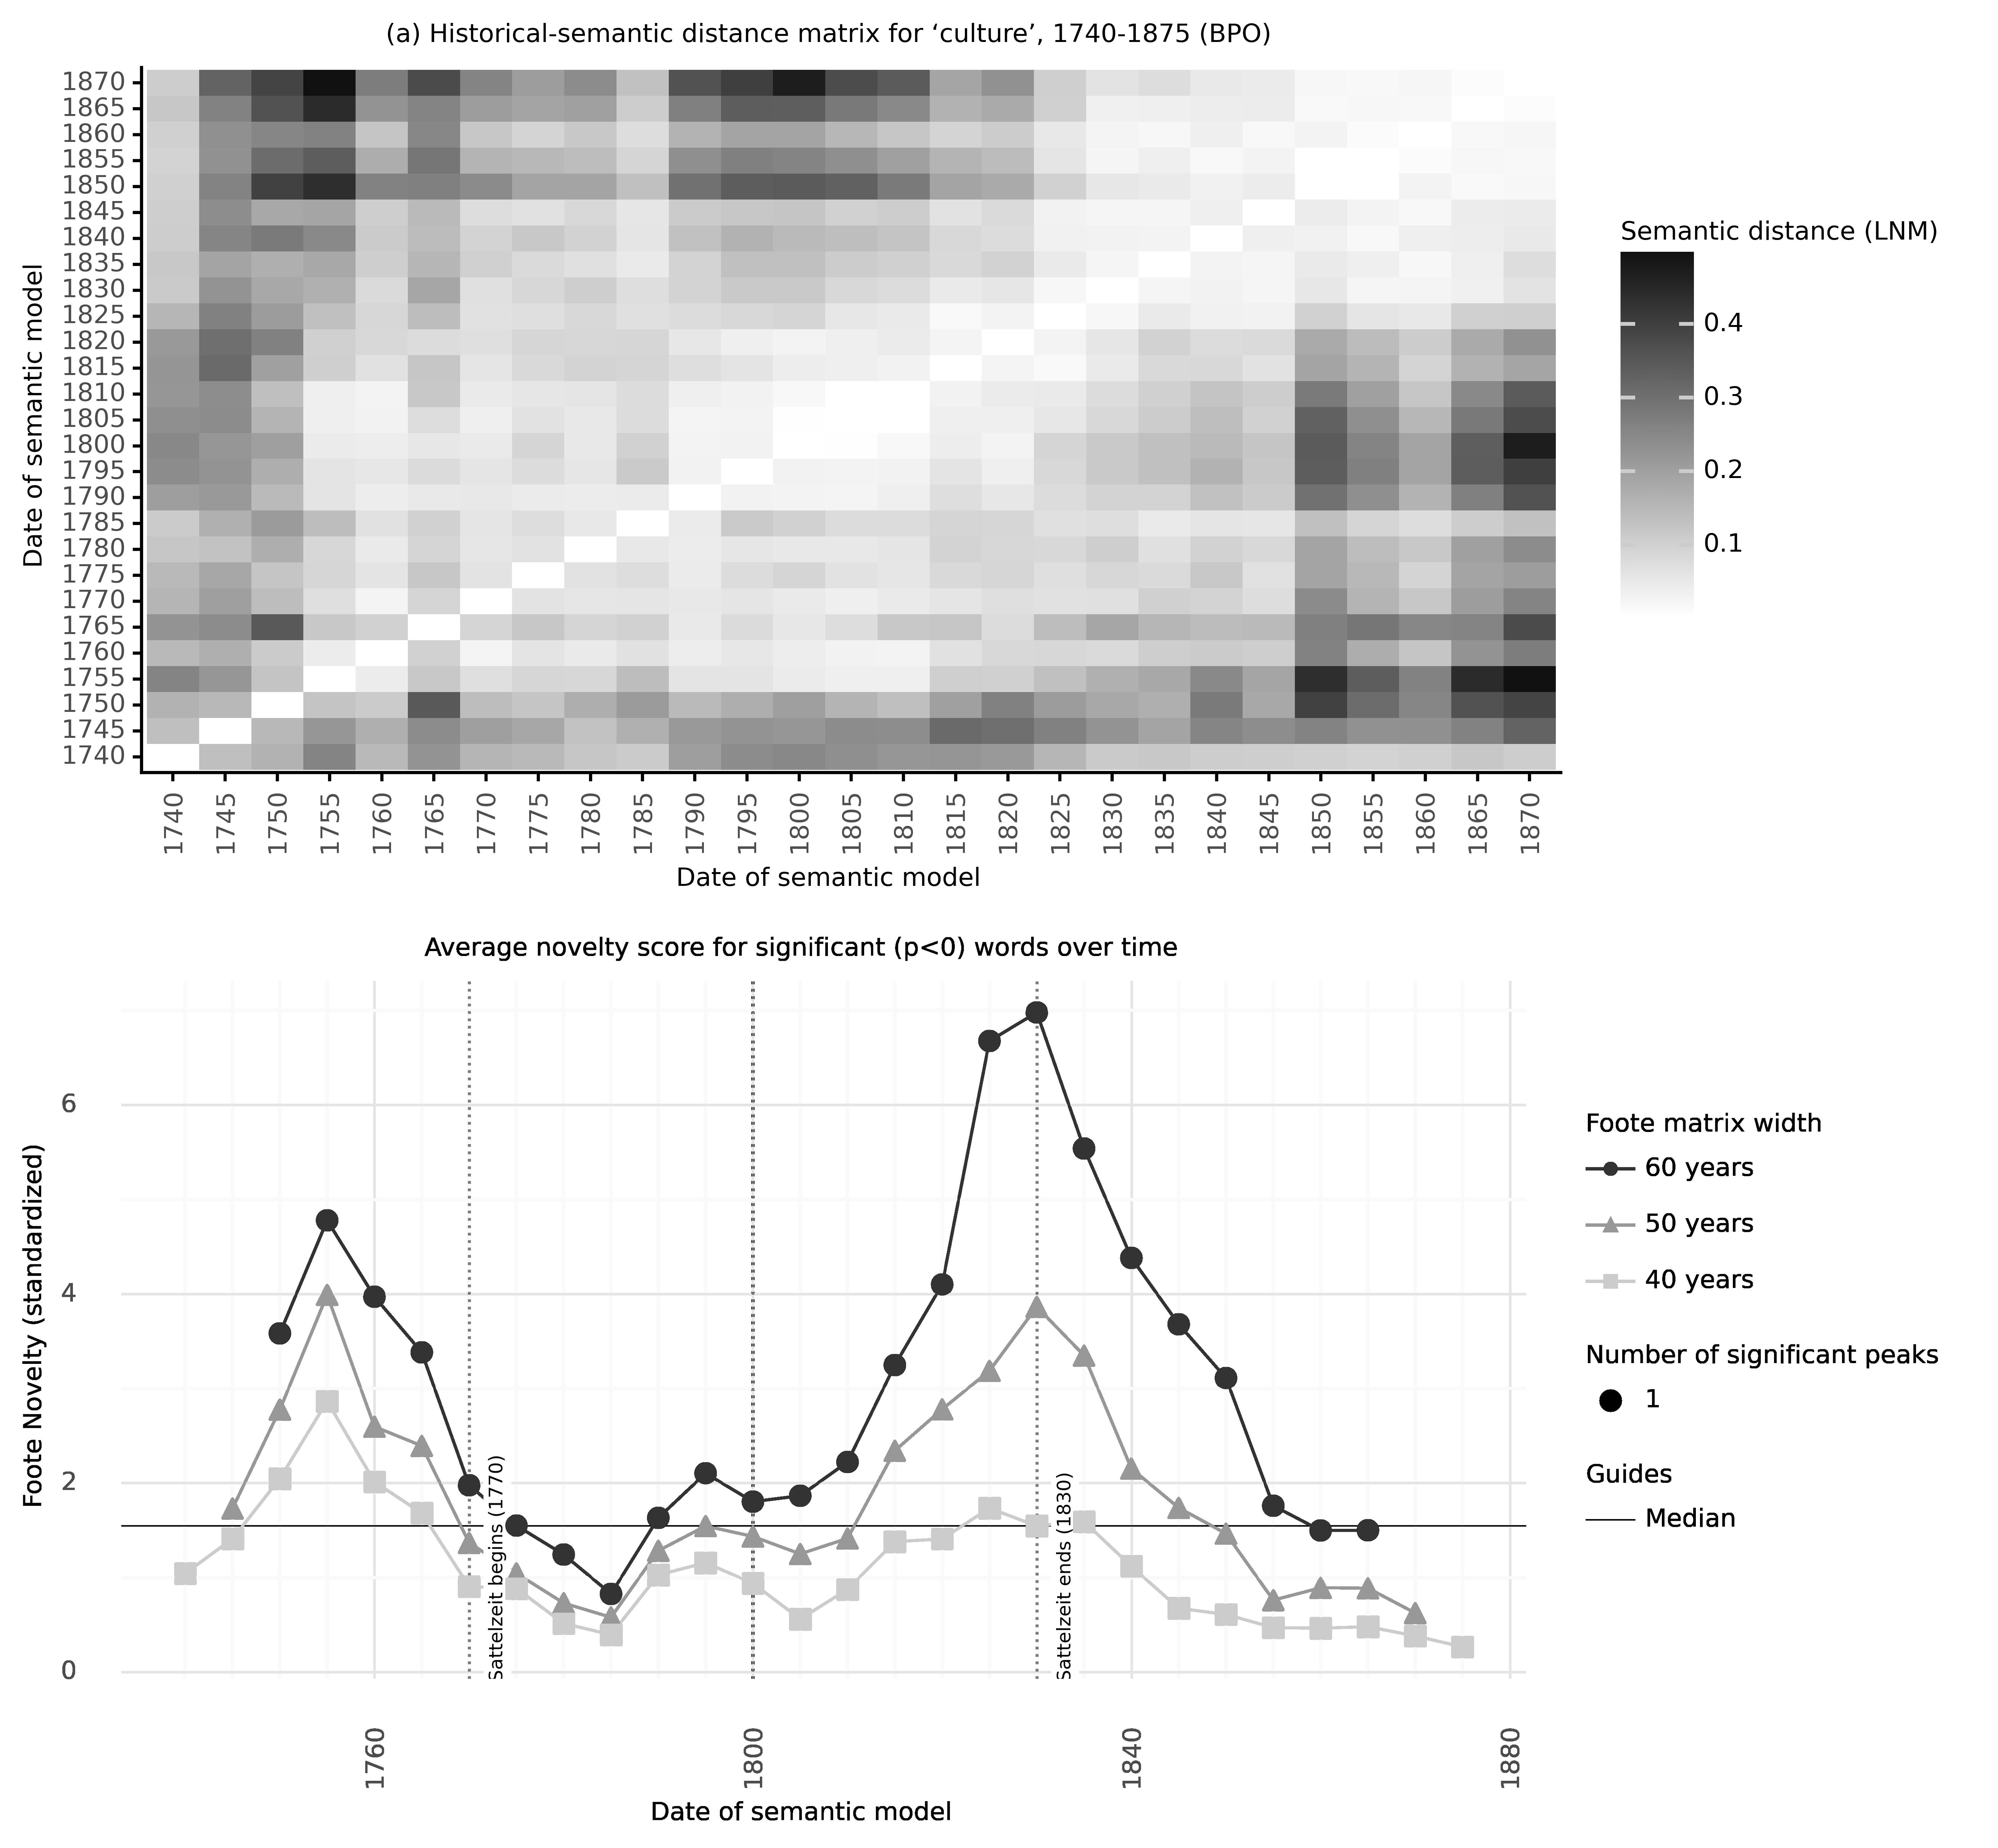

 > Uploading "/home/ryan/github/koselleck/figures/fig.footenov.v27.culture.cmbo.png" to "/Markdown/Drafts/TheGreatAbstraction/figures/fig.footenov.v27.culture.cmbo.png"... DONE
 > Share link: https://www.dropbox.com/s/15y5w8qazaiuw38/fig.footenov.v27.culture.cmbo.png?dl=0


In [35]:
show_novelty(
    min_foote_size=4,
    max_foote_size=6,
    rolling=1,
    max_p_peak=0,
    vnum='v27',
    save=0,#SAVE,
    words='culture',
    xlim0=1740,
    xlim1=1875,
    y='foote_novelty'
)

### Keywords

In [36]:
dfkw=get_keywords()

In [37]:
allres_f=allres.query('6<=foote_size<=6')
word_counts=allres_f.word.value_counts()
words_high_enough=set(word_counts[word_counts>=10].index)
len(words_high_enough)

5086

In [38]:
all_sign_words=set(allres.query('p_peak<0.05 & 1770<=year<1830').word)
len(all_sign_words)

703

In [39]:
len(all_sign_words & words_high_enough)

641

In [40]:
kws=set(dfkw[dfkw.in_author=='EDHI'].index) - {'value'}
# kws

In [41]:
sign_words=set(dfkw.index) & vsign_words
sign_words

NameError: name 'vsign_words' is not defined

In [ ]:
dfc=get_dfchange()
cleanwords=set(dfc[dfc.is_clean_noiseaware==True].index)
all_sign_words_clean=cleanwords&all_sign_words
len(all_sign_words_clean)

In [ ]:
# show_word_novelty(
#     #words='crisis,reform,demand,',
#     words=random.sample([
#         w for w in all_sign_words & set(word_counts[word_counts>=20].index) & cleanwords
#         if len(w)>4
#     ],10),
#     ylim0=0.5,ylim1=100,
# #     words=['despotism','communication','development','folk']
# )

### Many

In [ ]:
def show_mostnovel_df(querystr='',lim=None):
    dfc=get_dfchange()
    cleanwords=set(dfc[dfc.is_clean_noiseaware==True].index)
    lo=[]
    figdf=allres.query('6<=foote_size<=6 & p_peak<0.05')
    #.groupby(['year','word']).mean().reset_index()
#     figdf=figdf[figdf.word.isin(get_words_ever_abs())]
    for i,grp in figdf.groupby('year'):
        grp=grp.drop_duplicates('word').sort_values('foote_novelty',ascending=False)
        words_l=[
            f'{w} ({round(z,1)})'
            for w,z in zip(grp.word,grp.foote_novelty)
#             if w in cleanwords
            if w in (all_sign_words & cleanwords)
#             if 's' not in w and 'f' not in w and w in cleanwords
        ][:lim]
        random.shuffle(words_l)
        words=', '.join(words_l)
        lo+=[{'period':int(i), 'words':words}]
    odf=pd.DataFrame(lo)
    if querystr: odf=odf.query(querystr)
    printm(odf.set_index('period').to_markdown())

In [ ]:
show_mostnovel_df()